# House Price Prediction & Improvement Model

<font color=blue>_Patrice Kontchou, Chase Rendal, Lu Yu, Zack Zbar_

_NYC DSA bootcamp, June, 2020_

## Table of Contents
1. [Data Preparation](#data)
2. [Lasso](#lasso)
3. [Elastic Net](#en)
4. [Random Forest](#rf)
5. [Multiple Linear Regression](#mlr)

In [3]:
## Packages Required
# data wrangling
import numpy as np
import pandas as pd
import math
# statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# machine learning
from sklearn import datasets, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
# ploting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Settings
%matplotlib inline
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # combined with max_rows to show all rows 
pd.set_option('display.max_rows', None)  

## Data Input
<a id='data'></a>

In [5]:
## read in csv
trainf = pd.read_csv('../processed_data/train_full.csv')
traino = pd.read_csv('../processed_data/train_ordinal.csv')
traind = pd.read_csv('../processed_data/train_dummy.csv')
traindo = pd.read_csv('../processed_data/train_dummy_ordinal.csv')

FileNotFoundError: [Errno 2] File ../processed_data/train_dummy.csv does not exist: '../processed_data/train_dummy.csv'

In [ ]:
# get rid of extra id column
trainf.drop(['Unnamed: 0'],axis=1, inplace=True)
traind.drop(['Unnamed: 0'],axis=1, inplace=True)
traindo.drop(['Unnamed: 0'],axis=1, inplace=True)

In [ ]:
## set Id as index
trainf = trainf.set_index('Id')
traino = traino.set_index('Id')
traind = traind.set_index('Id')
traindo = traindo.set_index('Id')

In [ ]:
print(trainf.shape)
print(traino.shape)
print(traind.shape)
print(traindo.shape)

## Model Fitting

### 1. Lasso Regression
<a id='lasso'></a>

### _data set cleaning and transformation_

In [2]:
df = traindo.copy() # 
drop_rows = df[df.index.isin([524, 1299])].index
print("df shape before drop outlier rows:", df.shape)
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)

NameError: name 'traindo' is not defined

In [790]:
# remove outlier Id524, Id1299


df shape after drop outlier rows: (1458, 225)


In [794]:
## add log SalePrice
df["logSalePrice"] = df.SalePrice.map(lambda x: math.log(x))
df.head()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_fv,MSZoning_rh,MSZoning_rl,MSZoning_rm,Street_pave,Alley_nothing,Alley_pave,LotShape_ir2,LotShape_ir3,LotShape_reg,LandContour_hls,LandContour_low,LandContour_lvl,Utilities_nosewa,LotConfig_culdsac,LotConfig_fr2,LotConfig_fr3,LotConfig_inside,Neighborhood_blueste,Neighborhood_brdale,Neighborhood_brkside,Neighborhood_clearcr,Neighborhood_collgcr,Neighborhood_crawfor,Neighborhood_edwards,Neighborhood_gilbert,Neighborhood_idotrr,Neighborhood_meadowv,Neighborhood_mitchel,Neighborhood_names,Neighborhood_noridge,Neighborhood_npkvill,Neighborhood_nridght,Neighborhood_nwames,Neighborhood_oldtown,Neighborhood_sawyer,Neighborhood_sawyerw,Neighborhood_somerst,Neighborhood_stonebr,Neighborhood_swisu,Neighborhood_timber,Neighborhood_veenker,Condition1_feedr,Condition1_norm,Condition1_posa,Condition1_posn,Condition1_rrae,Condition1_rran,Condition1_rrne,Condition1_rrnn,Condition2_feedr,Condition2_norm,Condition2_posa,Condition2_posn,Condition2_rrae,Condition2_rran,Condition2_rrnn,BldgType_2fmcon,BldgType_duplex,BldgType_twnhs,BldgType_twnhse,HouseStyle_1.5unf,HouseStyle_1story,HouseStyle_2.5fin,HouseStyle_2.5unf,HouseStyle_2story,HouseStyle_sfoyer,HouseStyle_slvl,RoofStyle_gable,RoofStyle_gambrel,RoofStyle_hip,RoofStyle_mansard,RoofStyle_shed,RoofMatl_compshg,RoofMatl_membran,RoofMatl_metal,RoofMatl_roll,RoofMatl_tar&grv,RoofMatl_wdshake,RoofMatl_wdshngl,Exterior1st_asphshn,Exterior1st_brkcomm,Exterior1st_brkface,Exterior1st_cblock,Exterior1st_cemntbd,Exterior1st_hdboard,Exterior1st_imstucc,Exterior1st_metalsd,Exterior1st_plywood,Exterior1st_stone,Exterior1st_stucco,Exterior1st_vinylsd,Exterior1st_wd sdng,Exterior1st_wdshing,Exterior2nd_asphshn,Exterior2nd_brk cmn,Exterior2nd_brkface,Exterior2nd_cblock,Exterior2nd_cmentbd,Exterior2nd_hdboard,Exterior2nd_imstucc,Exterior2nd_metalsd,Exterior2nd_other,Exterior2nd_plywood,Exterior2nd_stone,Exterior2nd_stucco,Exterior2nd_vinylsd,Exterior2nd_wd sdng,Exterior2nd_wd shng,MasVnrType_brkface,MasVnrType_nothing,MasVnrType_stone,Foundation_cblock,Foundation_pconc,Foundation_slab,Foundation_stone,Foundation_wood,Heating_gasa,Heating_gasw,Heating_grav,Heating_othw,Heating_wall,CentralAir_y,Electrical_fusef,Electrical_fusep,Electrical_mix,Electrical_sbrkr,GarageType_attchd,GarageType_basment,GarageType_builtin,GarageType_carport,GarageType_detchd,GarageType_nothing,PavedDrive_p,PavedDrive_y,Fence_gdwo,Fence_mnprv,Fence_mnww,Fence_nothing,MiscFeature_nothing,MiscFeature_othr,MiscFeature_shed,MiscFeature_tenc,SaleType_con,SaleType_conld,SaleType_conli,SaleType_conlw,SaleType_cwd,SaleType_new,SaleType_oth,SaleType_wd,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,SaleCondition_partial,logSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65,8450,3,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,2003,2,2,548,3,3,0,61,0,0,0,0,0,0,2,2008,208500,10,10,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0

#### Single & alpha loop Lasso

In [582]:
## split to train & validation ##NOT needed, gridsearch does cv
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(['SalePrice', 'logSalePrice'], axis = 1), df.logSalePrice, test_size = 0.2, random_state = 4)

In [574]:
## single Lasso Pilot Test
lasso = Lasso(normalize=True)
lasso.set_params(alpha = 1e-4)
lasso.fit(xtrain, ytrain)
lasso_scores = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
lasso_scores

array([0.88277073, 0.91901358, 0.91559677, 0.92768813, 0.91692787])

In [464]:
## manual grid search of Lasso: varying alpha
lasso = Lasso(normalize=True)
alphas = np.linspace(1e-5, 1e-2, 100)

coefs_lasso = []
scores_lasso = []

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(xtrain, ytrain)
    coefs_lasso.append(lasso.coef_)
    lasso_score = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
    scores_lasso.append(lasso_score)
    
# lasso coef & score dataframe
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = xtrain.columns)
display(coefs_lasso.head())

scores_lasso = pd.DataFrame(scores_lasso, index = alphas, columns = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
display(scores_lasso.head())

scores_lasso['mean'] = scores_lasso.mean(axis =1)
display(scores_lasso.head())

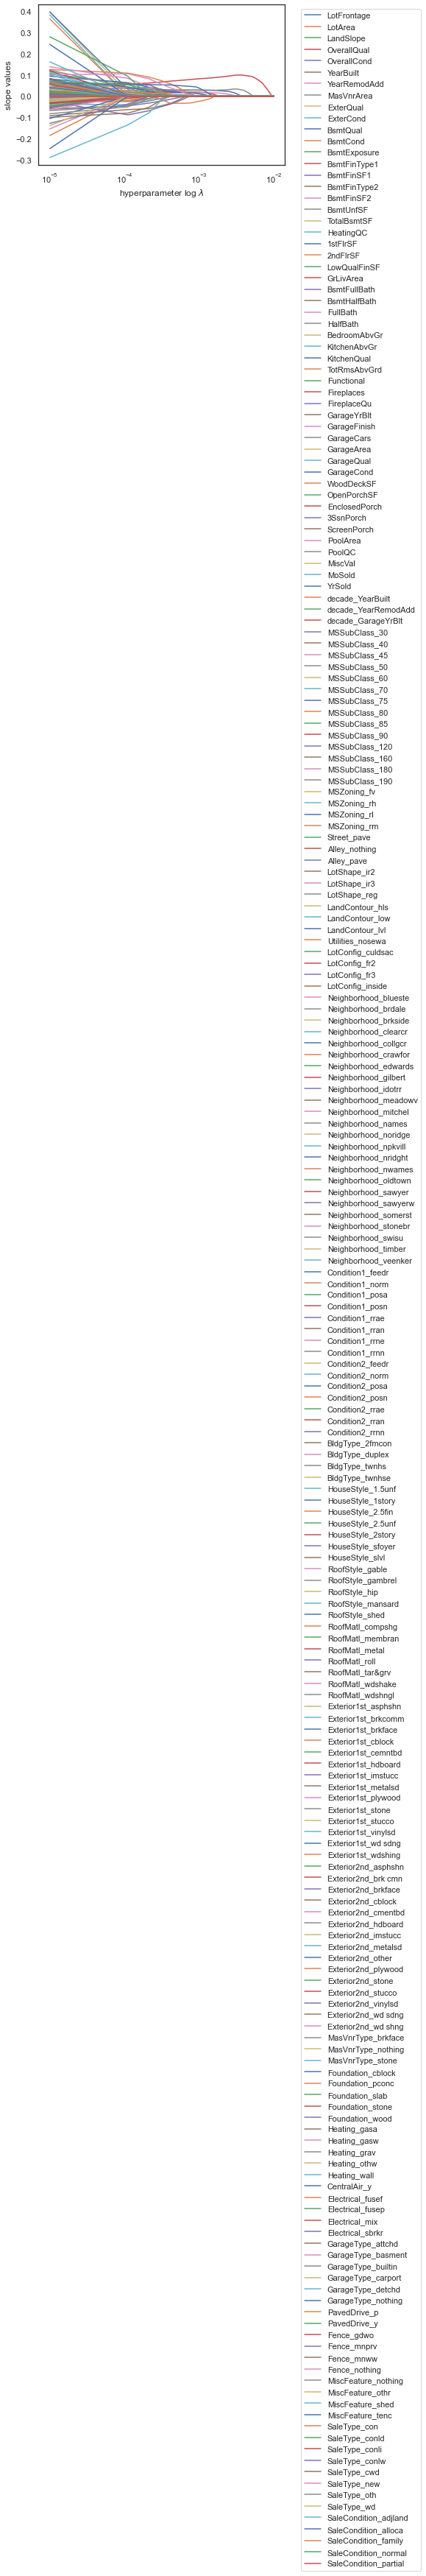

In [513]:
## Lasso hyperparameter plot
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
    plt.xscale("log") # optional
plt.xlabel(r'hyperparameter log $\lambda$')
plt.ylabel(r'slope values')
#plt.legend(loc = 1)
plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1.0))

In [548]:
## Lasso important predictors
#coefs_lasso[coefs_lasso.index>1e-3, ]
coefs_lasso[coefs_lasso.gt(0)]
coefs_lasso[coefs_lasso.gt(0)].sum(axis = 0).sort_values(ascending = False)
coefs_lasso[coefs_lasso.gt(0)].sum(axis = 0).sort_values(ascending = False)[0:10]

OverallQual             6.753186
GarageCars              1.366059
KitchenQual             0.792301
MSZoning_rl             0.629894
CentralAir_y            0.618254
Neighborhood_crawfor    0.534451
SaleType_new            0.434298
MSZoning_fv             0.416800
MSZoning_rh             0.381788
GarageFinish            0.374094
dtype: float64

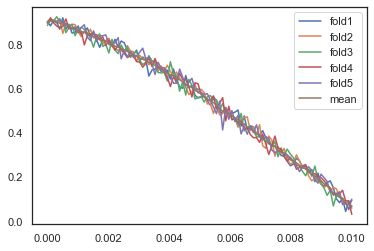

In [506]:
for name in scores_lasso.columns:
    plt.plot(scores_lasso.index, scores_lasso[name], label = name)
plt.legend(loc = 1)

#### Grid Search of Lasso

In [142]:
## Gridsearch of Lasso
alphas = np.linspace(1e-5, 1e-2, 100)
params_lasso = [{'alpha':alphas, 'max_iter': [2000]}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
grid_lasso = GridSearchCV(estimator = Lasso(normalize=True), param_grid = params_lasso, cv = kf5, 
                          scoring = 'neg_mean_squared_error', return_train_score = True, refit = True)
grid_lasso.fit(xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-05, 1.10909091e-04, 2...
       8.48636364e-03, 8.58727273e-03, 8.68818182e-03, 8.78909091e-03,
       8.89000000e-03, 8.99090909e-03, 9.09181818e-03, 9.19272727e-03,
       9.29363636e-03, 9.39454545e-03, 9.49545455e-03, 9.59636364e-03,
       9.69727273e-03, 9.79818182e-03, 9.89909091e-03, 1.00000000e-02]),
                          'max_iter': [2000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [143]:
print('score', grid_lasso.best_score_)
model_lasso = grid_lasso.best_estimator_
model_lasso

score -0.024234758048486474


Lasso(alpha=0.00021181818181818183, copy_X=True, fit_intercept=True,
      max_iter=2000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [148]:
lasso_coef = pd.DataFrame(model_lasso.coef_, index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
lasso_coef_abs = pd.DataFrame({'abs_coef':abs(model_lasso.coef_), 'coef': model_lasso.coef_}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
lasso_coef_imp = lasso_coef_abs[lasso_coef_abs['abs_coef']>0]
#display(lasso_coef_abs)
display(lasso_coef_imp)
print(f"# of predictors before Lasso:", lasso_coef_abs.shape[0])
print(f"# of predictors after Lasso:", lasso_coef_imp.shape[0])
# coef is for raw data, not for normalized data

# with open(filename, 'w') as csvfile：
#     csvwriter = csv.writer(csvfile)
#     writer.writerows(lasso_coef_impt.to_dict())

,abs_coef,coef
CentralAir,0.075100,0.075100
OverallQual,0.071892,0.071892
GarageCars,0.066040,0.066040
KitchenQual,0.039009,0.039009
PoolQC,0.035282,-0.035282
FullBath,0.035147,0.035147
BsmtFullBath,0.032441,0.032441
OverallCond,0.028568,0.028568
BsmtQual,0.027242,0.027242
SaleCondition,0.018183,0.018183


# of predictors before Lasso: 82
# of predictors after Lasso: 39


In [720]:
# Lasso Error
lasso_pred_train = model_lasso.predict(xtrain)
lasso_pred_test = model_lasso.predict(xtest)

MSE = mean_squared_error(ytrain, lasso_pred_train)
RMSE = np.sqrt(mean_squared_error(ytrain, lasso_pred_train)) # no written function, need to manually calculate like this
print(f"MSE is {MSE}\nRMSE is {RMSE}")

MSE is 0.011117486128894079
RMSE is 0.10543949036719628


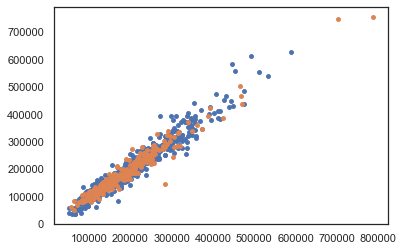

In [721]:
## plot error of train vs validataion data
ytrain_lasso = lasso_pred_train
ytest_lasso = lasso_pred_test

plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")
#plt.plot(logSalePrice, model_lasso.coef_[0]*logSalePrice + model_lasso.intercept_, label = "Lasso Regression Line", c= "C1", lw=3)

In [835]:
## Iterative Lasso
alphas = np.linspace(1e-5, 1e-2, 10)
params_lasso = [{'alpha':alphas, 'max_iter': [2000]}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
grid_lasso_iter = GridSearchCV(estimator = Lasso(normalize=True), param_grid = params_lasso, cv = kf5, 
                          scoring = 'neg_mean_squared_error', return_train_score = True, refit = True)
grid_lasso_iter.fit(xtrain_reduce, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00e-05, 1.12e-03, 2.23e-03, 3.34e-03, 4.45e-03, 5.56e-03,
       6.67e-03, 7.78e-03, 8.89e-03, 1.00e-02]),
                          'max_iter': [2000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [836]:
print('score', grid_lasso_iter.best_score_)
model_lasso_iter = grid_lasso.best_estimator_
model_lasso_iter
len(model_lasso_iter.coef_)

score -0.013731111795809558


224

## 2. Elastic Net
<a id='en'></a>

In [742]:
## drop non-important columns based on Lasso
df_reduce = df[lasso_coef_imp.index]
xtrain_reduce = xtrain[lasso_coef_imp.index]

In [815]:
rhos = np.linspace(0.1, 1, 10)
rhos = np.append(rhos, np.linspace(0.91, 0.99, 9))

In [816]:
## Gridsearch of ElasticNet
alphas = np.linspace(1e-10, 10, 100)
#rhos = np.linspace(0.1, 1, 10)
#rhos = np.linspace(0.801, 1, 100 )
params_elasticnet = [{'alpha': alphas, 'l1_ratio': rhos}]
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)
grid_elasticnet = GridSearchCV(estimator=ElasticNet(normalize=True), param_grid=params_elasticnet, return_train_score=True, refit=True)
grid_elasticnet.fit(xtrain_reduce, ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-10, 1.01010101e-01, 2.02020202e-01, 3.0303030...
       8.88888889e+00, 8.98989899e+00, 9.09090909e+00, 9.19191919e+00,
       9.29292929e+00, 9.39393939e+00, 9.49494949e+00, 9.59595960e+00,
       9.69696970e+00, 9.79797980e+00, 9.89898990e+00, 1.00000000e+01]),
                          'l1_ratio': array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [812]:
## best Elastic Net Model
print(grid_elasticnet.best_score_)
model_elasticnet = grid_elasticnet.best_estimator_
model_elasticnet

0.9144726195012909


ElasticNet(alpha=1e-10, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [813]:
## Elastic Net Model Coefficients
elasticnet_coef_abs = pd.DataFrame({'abs_coef':abs(model_elasticnet.coef_), 'coef': model_elasticnet.coef_}, 
                              index = xtrain_reduce.columns).sort_values(by = 'abs_coef', ascending = False)
elasticnet_coef_abs

,abs_coef,coef
RoofMatl_membran,0.219157,0.219157
Exterior1st_brkcomm,0.192958,-0.192958
Neighborhood_stonebr,0.132799,0.132799
Foundation_wood,0.132313,-0.132313
SaleType_new,0.129532,0.129532
Neighborhood_crawfor,0.127410,0.127410
RoofMatl_wdshngl,0.115342,0.115342
Street_pave,0.112111,0.112111
Neighborhood_meadowv,0.104931,-0.104931
Neighborhood_idotrr,0.104911,-0.104911


In [814]:
# Elastic Net Error
xtest_reduce = xtest[lasso_coef_imp.index]

elasticnet_pred_train = model_elasticnet.predict(xtrain_reduce)
elasticnet_pred_test = model_elasticnet.predict(xtest_reduce)

MSE = mean_squared_error(ytrain, elasticnet_pred_train)
RMSE = np.sqrt(mean_squared_error(ytrain, elasticnet_pred_train))
print(f"MSE is {MSE}\nRMSE is {RMSE}")

MSE is 0.010333701468993142
RMSE is 0.10165481527696138


In [ ]:
# Plot Elastic Nest Error
ytrain_elasticnet = elasticnet_pred_train
ytest_elasticnet = elasticnet_pred_test

plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")

## 3. Random Forest
<a id='rf'></a>

In [12]:
df = traino.copy()
df[df.applymap(np.isreal) == False].shape
#print(df.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,rl,65,8450,pave,nothing,reg,lvl,allpub,inside,3,collgcr,norm,norm,1fam,2story,7,5,2003,2003,gable,compshg,vinylsd,vinylsd,brkface,196,4,3,pconc,4,3,1,6,706,1,0,150,856,gasa,5,y,sbrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,attchd,2003,2,2,548,3,3,y,0,61,0,0,0,0,0,nothing,nothing,0,2,2008,wd,normal,208500,10,10,10
2,20,rl,80,9600,pave,nothing,reg,lvl,allpub,fr2,3,veenker,feedr,norm,1fam,1story,6,8,1976,1976,gable,compshg,metalsd,metalsd,nothing,0,3,3,cblock,4,3,4,5,978,1,0,284,1262,gasa,5,y,sbrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,attchd,1976,2,2,460,3,3,y,298,0,0,0,0,0,0,nothing,nothing,0,5,2007,wd,normal,181500,7,7,7
3,60,rl,68,11250,pave,nothing,ir1,lvl,allpub,inside,3,collgcr,norm,norm,1fam,2story,7,5,2001,2002,gable,compshg,vinylsd,vinylsd,brkface,162,4,3,pconc,4,3,2,6,486,1,0,434,920,gasa,5,y,sbrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,attchd,2001,2,2,608,3,3,y,0,42,0,0,0,0,0,nothing,nothing,0,9,2008,wd,normal,223500,10,10,10
4,70,rl,60,9550,pave,nothing,ir1,lvl,allpub,corner,3,crawfor,norm,norm,1fam,2story,7,5,1915,1970,gable,compshg,wd sdng,wd shng,nothing,0,3,3,brktil,3,4,1,5,216,1,0,540,756,gasa,4,y,sbrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,detchd,1998,1,3,642,3,3,y,0,35,272,0,0,0,0,nothing,nothing,0,2,2006,wd,abnorml,140000,1,7,9
5,60,rl,84,14260,pave,nothing,ir1,lvl,allpub,fr2,3,noridge,norm,norm,1fam,2story,8,5,2000,2000,gable,compshg,vinylsd,vinylsd,brkface,350,4,3,pconc,4,3,3,6,655,1,0,490,1145,gasa,5,y,sbrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,attchd,2000,2,3,836,3,3,y,192,84,0,0,0,0,0,nothing,nothing,0,12,2008,wd,normal,250000,10,10,10


In [66]:
df["logSalePrice"] = df.SalePrice.map(lambda x: math.log(x))
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt,logSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,rl,65,8450,pave,nothing,reg,lvl,allpub,inside,3,collgcr,norm,norm,1fam,2story,7,5,2003,2003,gable,compshg,vinylsd,vinylsd,brkface,196,4,3,pconc,4,3,1,6,706,1,0,150,856,gasa,5,y,sbrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,attchd,2003,2,2,548,3,3,y,0,61,0,0,0,0,0,nothing,nothing,0,2,2008,wd,normal,208500,10,10,10,12.247694
2,20,rl,80,9600,pave,nothing,reg,lvl,allpub,fr2,3,veenker,feedr,norm,1fam,1story,6,8,1976,1976,gable,compshg,metalsd,metalsd,nothing,0,3,3,cblock,4,3,4,5,978,1,0,284,1262,gasa,5,y,sbrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,attchd,1976,2,2,460,3,3,y,298,0,0,0,0,0,0,nothing,nothing,0,5,2007,wd,normal,181500,7,7,7,12.109011
3,60,rl,68,11250,pave,nothing,ir1,lvl,allpub,inside,3,collgcr,norm,norm,1fam,2story,7,5,2001,2002,gable,compshg,vinylsd,vinylsd,brkface,162,4,3,pconc,4,3,2,6,486,1,0,434,920,gasa,5,y,sbrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,attchd,2001,2,2,608,3,3,y,0,42,0,0,0,0,0,nothing,nothing,0,9,2008,wd,normal,223500,10,10,10,12.317167
4,70,rl,60,9550,pave,nothing,ir1,lvl,allpub,corner,3,crawfor,norm,norm,1fam,2story,7,5,1915,1970,gable,compshg,wd sdng,wd shng,nothing,0,3,3,brktil,3,4,1,5,216,1,0,540,756,gasa,4,y,sbrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,detchd,1998,1,3,642,3,3,y,0,35,272,0,0,0,0,nothing,nothing,0,2,2006,wd,abnorml,140000,1,7,9,11.849398
5,60,rl,84,14260,pave,nothing,ir1,lvl,allpub,fr2,3,noridge,norm,norm,1fam,2story,8,5,2000,2000,gable,compshg,vinylsd,vinylsd,brkface,350,4,3,pconc,4,3,3,6,655,1,0,490,1145,gasa,5,y,sbrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,attchd,2000,2,3,836,3,3,y,192,84,0,0,0,0,0,nothing,nothing,0,12,2008,wd,normal,250000,10,10,10,12.429216


In [67]:
def text_to_num(x):
    '''get a column as param and return column coded in numeric
    from 1 to len of columns'''
    feature = set(x.to_list())
    #get a mapping of feature with their index from 1
    feature_dict = dict(zip( sorted(feature),range(1,len(feature)+1)))
    return x.map(feature_dict)

In [84]:
#get only categorical columns
text_col = df[~df.applymap(np.isreal)].dropna(axis=1).columns
#transform apply function on text columns and create a temp df
num_col = df[text_col].apply(text_to_num)
#Drop text column and merge data frame to create a full df.
tran_df = pd.concat((df.drop(text_col, axis = 1),num_col), axis=1)
tran_df.head()
tran_df.shape

(1460, 84)

In [61]:
## convert nominal to ordinal (integer)
# 1) if only allow 1 cut, the nomial mapping matters, but if allow more cuts, may compensate that
# 2) find some ordinal structure, replace with mean value per each category; reduce to ordinal, by boxplot, low-high

def convert_to_num(df, col):
    options = df[col].unique()
    convert = pd.DataFrame(range(len(options)), options).to_dict()
    new = options
    return new

# options = convert_to_num(df, "Neighborhood")
# options

# target = df.Neighborhood
# diction = pd.DataFrame(range(len(options)), options).to_dict()
# diction
# for key in diction:
#     print(key, diction[key])
# new = [diction[key] for key in diction]
# new

In [69]:
## split to train & validation ##NOT needed, gridsearch does cv
xtrain, xtest, ytrain, ytest = train_test_split(tran_df.drop(['SalePrice', 'logSalePrice'], axis = 1), tran_df.logSalePrice, test_size = 0.2, random_state = 4)

In [171]:
rfreg = RandomForestRegressor(random_state=4, max_features=40, oob_score = True, 
                              n_estimators = 700, min_samples_leaf = 20, max_depth = 51)
rfreg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=51, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [172]:
# random forest prediction
#randomforest_pred_train = rfreg.predict(xtrain)
#randomforest_pred_test = rfreg.predict(xtest)
#MSE = mean_squared_error(ytrain, randomforest_pred_train)
#print(f"MSE is {MSE}")
print("train score is", rfreg.score(xtrain, ytrain))
#print("oob score is", rfreg.oob_score_)

k5 = KFold(5, random_state=4, shuffle=True)
cv_score = cross_val_score(rfreg, xtrain, ytrain, cv = k5).mean()
print("validation score is", cv_score)
# feature_importance = list(zip(xtrain.columns[:], rfreg.feature_importances_))
# pd.DataFrame(feature_importance, columns = ["predictor", "importance"]).sort_values(by = "importance", ascending=False)

score is 0.8759945103082944


0.8323881001686374

In [165]:
#list(range(0,90, 10))
#list(range(100, 500, 100))
list(range(300, 1001, 100))

[300, 400, 500, 600, 700, 800, 900, 1000]

In [168]:
## randomsearch for random forest
params_rf = [{'max_features': range(10,51,10), 'n_estimators': range(200, 1001, 100), 
              'max_depth': range(1,81,10), 'min_samples_leaf': range(10,31,5)}]
random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=4, oob_score = True), param_distributions = params_rf, 
                               n_iter = 100, cv = 5, verbose = 2, random_state=4)
%time random_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21, total=   5.4s
[CV] n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21, total=   6.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21, total=   3.8s
[CV] n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21, total=   6.8s
[CV] n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=10, max_depth=21, total=   6.1s
[CV] n_estimators=600, min_samples_leaf=20, max_features=20, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=20, max_depth=61, total=   8.0s
[CV] n_estimators=600, min_samples_leaf=20, max_features=20, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=20, max_features=20, max_depth=61, total=   3.2s
[CV] n_estimators=600, min_samples_leaf=20, max_features=20, max_depth=61 
[CV]  n_es

[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61, total=   4.4s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61, total=   4.1s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61, total=   6.7s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=61, total=   5.6s
[CV] n_estimators=700, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=40, max_depth=51, total=  11.6s
[CV] n_estimators=700, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=40, max_depth=51, total=   9.0s
[CV] n_estimators=700, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_es

[CV]  n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31, total=   2.6s
[CV] n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31, total=   2.4s
[CV] n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31, total=   3.3s
[CV] n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=10, max_depth=31, total=   2.6s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=40, max_depth=41 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=40, max_depth=41, total=   7.8s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=40, max_depth=41 
[CV]  n_estimators=1000, min_samples_leaf=30, max_features=40, max_depth=41, total=  10.1s
[CV] n_estimators=1000, min_samples_leaf=30, max_features=40, max_depth=41 
[CV] 

[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61, total=   4.6s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61, total=   3.9s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61, total=   4.0s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=61, total=   3.9s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=31 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=31, total=   6.2s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=31 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=31, total=   6.2s
[CV] n_estimators=700, min_samples_leaf=10, max_features=50, max_depth=31 
[CV]  n_es

[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11, total=   6.1s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11, total=   7.3s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11, total=   4.8s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=11, total=   4.7s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=21 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=21, total=   3.4s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=21 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=21, total=   3.3s
[CV] n_estimators=600, min_samples_leaf=15, max_features=10, max_depth=21 
[CV]  n_es

[CV]  n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31, total=   9.2s
[CV] n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31, total=   9.3s
[CV] n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31, total=   7.2s
[CV] n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=40, max_depth=31, total=   6.0s
[CV] n_estimators=500, min_samples_leaf=20, max_features=50, max_depth=51 
[CV]  n_estimators=500, min_samples_leaf=20, max_features=50, max_depth=51, total=   6.2s
[CV] n_estimators=500, min_samples_leaf=20, max_features=50, max_depth=51 
[CV]  n_estimators=500, min_samples_leaf=20, max_features=50, max_depth=51, total=   6.2s
[CV] n_estimators=500, min_samples_leaf=20, max_features=50, max_depth=51 
[CV]  n_es

[CV]  n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11, total=   9.2s
[CV] n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11, total=   6.4s
[CV] n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11, total=   5.6s
[CV] n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11 
[CV]  n_estimators=700, min_samples_leaf=10, max_features=10, max_depth=11, total=   9.0s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=21 
[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=21, total=   9.7s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=21 
[CV]  n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=21, total=   6.6s
[CV] n_estimators=700, min_samples_leaf=25, max_features=50, max_depth=21 
[CV]  n_es

[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61, total=   2.1s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61, total=   2.1s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61, total=   2.3s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=61, total=   2.1s
[CV] n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=1 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=1, total=   3.3s
[CV] n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=1 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=1, total=   3.2s
[CV] n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=1 
[CV]  n_estimat

[CV]  n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71, total=   5.8s
[CV] n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71, total=   5.3s
[CV] n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71, total=   5.6s
[CV] n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=20, max_depth=71, total=  11.5s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=50, max_depth=1 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=50, max_depth=1, total=   8.1s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=50, max_depth=1 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=50, max_depth=1, total=   7.3s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=50, max_depth=1 
[CV]  n_es

[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21, total=   6.3s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21, total=   6.4s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21, total=   6.4s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=21, total=   6.3s
[CV] n_estimators=400, min_samples_leaf=15, max_features=10, max_depth=51 
[CV]  n_estimators=400, min_samples_leaf=15, max_features=10, max_depth=51, total=   2.1s
[CV] n_estimators=400, min_samples_leaf=15, max_features=10, max_depth=51 
[CV]  n_estimators=400, min_samples_leaf=15, max_features=10, max_depth=51, total=   2.2s
[CV] n_estimators=400, min_samples_leaf=15, max_features=10, max_depth=51 
[CV]  n_es

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 46.9min finished


CPU times: user 27min 15s, sys: 1min 1s, total: 28min 17s
Wall time: 47min 5s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [169]:
print(random_rf.best_params_)
print(random_rf.best_score_) # validation score
print(random_rf.best_estimator_)
model_rf = random_rf.best_estimator_
model_rf.fit(xtrain, ytrain)

{'n_estimators': 700, 'min_samples_leaf': 10, 'max_features': 40, 'max_depth': 51}
0.851421758752311
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=51, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=51, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [170]:
model_rf.score(xtrain, ytrain)

0.9108719955527298

In [140]:
## gridsearch of random forest
params_rf_grid = [{'max_features': range(0,81,10), 'n_estimators': range(100, 501, 5), 
              'max_depth': range(10,101,10), 'min_samples_leaf': range(1,21,1),
             "criterion": ["mse", "mae"]}]

grid_rf = GridSearchCV(RandomForestRegressor(random_state=4, oob_score = True), params_rf_grid, cv=5, n_jobs=-1, verbose = 2, scoring= "neg_mean_squared_error")
%time grid_rf.fit(xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
display(grid_rf.best_params_)
display(grid_rf.best_score_)
print("The training error is: %.5f" % (1 - grid_rf.score(xtrain, ytrain)))
print("The test error is: %.5f" % (1 - grid_rf.score(xtest, ytest)))

In [ ]:
# plot for random forest
## plot error of train vs validataion data
ytrain_rf = lasso_pred_train
ytest_rf = lasso_pred_test

plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")

## 4. Multiple Linear Regression 
_**home improvement for homeowners**_
<a id='mlr'></a>

In [ ]:
# features from Lasso?
# multicollinearity still exits, still need to do feature selection / engineer